## Machine Learning and Artificial Intelligence 
Summer High School Academic Program for Engineers (2025)
## 6 - Understanding Words and Text: Neural Language Models 

**Author:** <a href="https://www.cs.columbia.edu/~bauer">Daniel Bauer &lt;bauer@cs.columbia.edu&gt;</a>

So far we encountered different types of inputs to our learning problems: tabular data and images. We saw that CNNs were useful for creating feature representations for images that we can then feed into a classifier. 
But what about text? 

Assume we have a bunch of movie reviews and we want to classify them into positive and negative sentiment. 

> This movie was absolutely fantastic! The storyline was gripping, the acting was top-notch, and the cinematography was breathtaking. I was on the edge of my seat the entire time. Highly recommended! 👍

or 

> I was really disappointed with this movie. The plot was predictable and the characters were flat. It felt like a waste of time. Definitely not worth watching. 👎

We need to find a way of encoding each review as a vector so we can feed it into a classifier. To do this, we need to figure out how to represent individual words, combine them into sequence representations, and we need to deal with the issue that text can be arbitrarily long sequences (unlike images which can be scaled and cropped to a specific input size). 

We will start with the problem of representing words and will then revisit sequence encoding later. 

### Types, Tokens, and Word Vectors

The individual word occurences in a text are called **tokens** (counting words that appear more than once multiple times). 
The different words in a text (not counting duplicates) are the **types**. For example in the sequence "to be or not to be" there are 6 tokens but only 4 types "to", "be", "or", and "not".

The inventory of possible types that may appear in a text (and that our models will know about) is called the **vocabulary**. One issue we will have to deal with is tokens that appear in the test data that were not seen during training. 

**Words as Vectors** 

How should we represent the individual types in the vocabulary as vectors? A simple option would be to use a 1-hot vector with one dimension for each type in the vocabulary. For example: 

`[[dog]] = [0,0,..0,1,0,...0]
[[cat]] = [0,0,..0,0,1,...0]`


But considering a typical vocabulary contains more than 10,000 types, this becomes impractical. Neural networks also have trouble learning with sparse vectors (where most components are 0). 
More importantly, these 1-hot vectors do not tell us anything about what the words *mean* or how they may interact in a sentence. For example, we would ideally want the vector for [[dog]] and [[cat]] to be similar. But any non-identical pair of 1-hot vectors will have a dot product of 0. 

We would therefore like to produce some lower-dimensional (typically between 100 and 1,000 components) dense vector repersentation (where few or none of the components are 0. We want similar vectors for types that are semantically similar, in the sense that they may appear in similar contexts in a sentence! These dense vectors are known as **word embeddings**. The idea that the context(s) that a word appears in tells us something about its meaning is called the **distributional hypothesis**. For example "they adopted a dog" and "they adopted a cat", "he fed the dog", "she fed the cat". 

In [32]:
import numpy as np

dog = np.array([
    0.12, -0.34, 0.56, 0.78, -0.45,
    0.23, 0.67, -0.12, -0.89, 0.34,
    0.05, -0.22, 0.11, 0.44, -0.31,
    0.09, 0.71, -0.65, 0.38, -0.07,
    0.53, -0.48, 0.25, -0.13, 0.47,
    -0.28, 0.19, 0.64, -0.55, 0.30,
    0.42, -0.37, 0.15, 0.26, -0.50,
    0.33, -0.21, 0.60, -0.12, 0.49,
    -0.44, 0.20, 0.58, -0.31, 0.07,
    0.14, -0.29, 0.39, -0.22, 0.61
])

cat = np.array([
    0.15, -0.30, 0.52, 0.81, -0.40,
    0.20, 0.65, -0.10, -0.85, 0.38,
    0.08, -0.25, 0.14, 0.48, -0.28,
    0.11, 0.74, -0.60, 0.35, -0.05,
    0.50, -0.45, 0.28, -0.11, 0.43,
    -0.25, 0.22, 0.60, -0.52, 0.27,
    0.40, -0.34, 0.18, 0.22, -0.47,
    0.37, -0.19, 0.63, -0.10, 0.52,
    -0.41, 0.25, 0.54, -0.28, 0.10,
    0.17, -0.32, 0.35, -0.18, 0.58
])

np.dot(dog, cat) 

8.3703

In [33]:
def cos(u,v): 
    magnitude_u = np.linalg.norm(u)
    magnitude_v = np.linalg.norm(v)
    return np.dot(u,v) / (magnitude_u * magnitude_v)

cos(dog,cat)

0.9970969424287919

Ensuring that similar words also have similar vector representations will allow the neural network models to learn generalizations.

### Language Model and Next Word Prediction

The goal of language modeling is to assign a probability to a sequence of tokens. This can be useful in tasks where we want to compare two different outputs, for example candidate translations in a machine translation system: we simply select the one with the higher probability. 

The probability of a sequence factors into the individual word probabilities, where each token is conditioned on all other token in the sentence. Typically we assume that each token is only conditions on the words to the left (since text is read/written/spoken from left-to-right) and that there is a limited horizon of $k-1$ tokens to consider (the limited horizon assumption is known as the **Markov Assumption**). For example if $k=3$, each token depends on the previous two. 

$$P(w_1, \ldots, w_T) = P(w_1 | START, START) P(w_2 | START, w_1) P(w_3 | w_1, w_2) \cdots P(w_T | w_{T-2} w_{T-1}) P(STOP | w_T  w_{T-1})$$

We can thus train a model to take in two **context tokens** $w_{i-1}$ and $w_{i-2}$ and predict a probability distribution for possible **successor tokens** $w_i$. The task we are solving is **next word prediction**. Here is what the model might look like schematically:

<img src="https://www.cs.columbia.edu/~bauer/shape/neural_lm.png" width=500px>

This problem is far from trivial. The output vocabulary is huge (10000 types or more) and there are often many possibilities for good successor words. 

If we represent the input words as one-hot vectors, the model will not be able to learn this effectively. Note that only one of the connections for each word from the input layer to the hidden layer would be active. The model may be able to memorize the specific input/output pairs we provide, but it would never be able to *generalize* to unseen inputs. For example, if we see "through the prettiest" then "garden" might still be a good next word. That's because "through" and "into" are similar, as are "loveliest" and "prettiest". 

**Language Models as Generator**
Language models can also be used as generators. We start with the start context, then predict a probability distribution for the first word. We sample from this distribution to select a word. Then we concatenate that word with the context, apply the model to predict the next word, etc. This is, essentially, how LLMs generate output text (but, as we will see, with some additional tricks to make the language model much beter).


### Learning Embedding Matrices

The key to making this work is to learn **word embeddings**, dense low-dimensional word representations, as part of the prediction task in a separate hidden layer. 
We want all context words to share the same representation, so that a word like "loveliest" has the same representation no matter its input position. To do this, we use the same weight matrix for each input position. 

<img src="https://www.cs.columbia.edu/~bauer/shape/neural_lm_embeddings.png" width=600px>

Note that the embedding layer does not use an activation function. The activations at this layer therefore correspond to the embeddings of each input word, which are simpy the rows of the embdding matrix $E$. For example, this may be a $(150 \times 10,000)$ matrix if our vocabulary is $10,000$ types and we want $150$ embedding dimensions. We learn the embdding weights like any other weight matrix. 


There are other approaches to learning these embeddings, such as the word2vec or GloVe models -- however they are all based on the same idea as the neural LM: learning to associate the context of a word (usually bidirectional context) with a target word.

### Implementing a Neural LM

We are going to use the Brown corpus, a carefully curated collection of about 1 million words of written American English, compiled from a variety of sources published in 1961. The Brown corpus has been historically significant in computational linguistics. 

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class BrownDataset(Dataset): 

    def __init__(self,filename, k=3,vocab_size = 10000, id_to_word = None): 


        if not id_to_word: 
            # First, obtain the vocabulary, we will use the vocab_size most frequent words
            vocab_count = Counter()
            with open(filename,'r') as f: 
                for line in f: 
                    tokens = line.strip().lower().split() # this version is pre-tokenized, so we don't have to do much work    
                    vocab_count.update(tokens)
            vocab = [t for t,count in vocab_count.most_common(vocab_size-3)] # reserve 3 entries in the vocab for special symbols
            # add special symbols
            vocab.insert(0,"UNK")
            vocab.insert(0,"END")
            vocab.insert(0,"START")
            self.id_to_word = dict(enumerate(vocab))
        else: 
            self.id_to_word = id_to_word
            
        self.word_to_id = {word:ident for ident,word in self.id_to_word.items()}

        # now obtain the n-grams
        self.ngrams = []
        with open(filename,'r') as f: 
            for line in f: 
                tokens = line.strip().lower().split() # this version is pre-tokenized, so we don't have to do much work            
                tokens = ["START"]*(k-1) + tokens + ["END"] # pad with start and end
                tokens = [t if (t in self.word_to_id) else "UNK" for t in tokens] #replace unknown tokens            
                
                ngrams = [tokens[i:i+k] for i in range(len(tokens)-k+1)]            
                self.ngrams.extend(ngrams)                    
        
    def __len__(self): 
        return len(self.ngrams)

    def __getitem__(self, k):
        ngram = self.ngrams[k]
        context = torch.tensor([self.word_to_id[w] for w in ngram[:-1]])
        target = torch.tensor(self.word_to_id[ngram[-1]])
        return context,target

In [35]:
data = BrownDataset("brown_train.txt",k=4)

In [38]:
data[1]

(tensor([0, 0, 3]), tensor(4906))

In [39]:
data.id_to_word[4906]

'fulton'

Then define the model:

In [40]:
from torch import nn

class TrigramLM(nn.Module):
    def __init__(self, vocab_size, k=4, emb_dim=128, hidden_dim=512):
    
        super().__init__()
        
        self.E = nn.Embedding(vocab_size, emb_dim) 
        self.hidden = nn.Linear(emb_dim*(k-1), hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        emb = self.E(x)                     # (batch, context length, emb_dim)
        flattened = emb.view(x.size(0), -1) # flatten to (batch, 3*emb_dim)
        h = self.relu(self.hidden(flattened))
        h = self.dropout(h)
        out = self.out(h)
        return out

In [42]:
vocab_size = len(data.id_to_word)
model = TrigramLM(vocab_size)
x,y = data[0]
model(x.unsqueeze(0)).shape

torch.Size([1, 10000])

In [10]:
from torch import optim 
from tqdm import tqdm

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001, device='cuda'):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(context)
            loss = loss_fn(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * context.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [11]:
train_loader = DataLoader(data, batch_size = 256, shuffle=True)

In [70]:
train_model(model, train_loader, num_epochs=5)

100%|██████████| 4073/4073 [00:21<00:00, 193.16it/s]


Epoch 1/5: Train Loss: 4.5635, Train Acc: 0.2233


100%|██████████| 4073/4073 [00:19<00:00, 208.82it/s]


Epoch 2/5: Train Loss: 4.5144, Train Acc: 0.2245


100%|██████████| 4073/4073 [00:19<00:00, 203.65it/s]


Epoch 3/5: Train Loss: 4.4658, Train Acc: 0.2262


100%|██████████| 4073/4073 [00:19<00:00, 210.99it/s]


Epoch 4/5: Train Loss: 4.4211, Train Acc: 0.2272


100%|██████████| 4073/4073 [00:20<00:00, 202.61it/s]

Epoch 5/5: Train Loss: 4.3842, Train Acc: 0.2288


#### Generating text 

We can use the model to generate text by sampling from the distribution of each successor token and then updating the context.  

In [71]:
def generate(max_len = 10, prefix = '', k=4):
    model.eval()
    device = next(model.parameters()).device
    if not prefix:         
        context = ['START'] * (k-1)
    else: 
        context = prefix.split() # in case a prefix string has been provided 
        
    sentence = context[:]
    for i in range(max_len):
        ctx_idx = torch.tensor([data.word_to_id[x] for x in context]).unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(ctx_idx)[0]
            probs = torch.softmax(prediction, 0)
            next_token = torch.multinomial(probs, 1).item()
        next_word = data.id_to_word[next_token]
        if next_word == 'END':
            break
        sentence.append(next_word)
        context = context[1:] + [next_word]
    return ' '.join(sentence)



In [72]:
generate(20)

"START START START then , the forces for eye '' , the american UNK which you know how a little approach in the"

#### Evaluation

How do we know how well our model is doing? Measuring accuracy on the test data is not an informative metric, since there are usually many "good" ways of completing the context -- the next word is usually ambiguous. Even on the training data, a neural LM will never reach super-high accuracy. 

But we can look at the probability that the model assigns to the test data. More specifically, we are looking at the perplexity, which normalizes the probabilities so they become comparable across test corpora of different lengths. 

Perplexity is defined as 

$e^l$ where $l = \frac{1}{N}\sum\limits_{i=1}^N {- \log_e P(w_i)}$.

$- \log P(w_i)$ is the negative log-likelihood the model assigns to each token in the test data. 

In [73]:
import torch.nn.functional as F 

def evaluate(model, dataloader, device='cuda'):
    model.eval()
    total_nll = 0.0
    total_words = 0

    with torch.no_grad():
        for context, target in dataloader:            
                context = context.to(device)
                target = target.to(device)
                prediction = model(context)            # (batch, vocab_size)
                nll = F.cross_entropy(prediction, target, reduction='sum').item()
                total_nll += nll
                total_words += target.size(0)

    avg_nll = total_nll / total_words
    ppl = np.exp(avg_nll)
    print(f"Perplexity: {ppl:.2f}")
    return ppl

In [74]:
test_data = BrownDataset("brown_test.txt",k=4, id_to_word = data.id_to_word)

In [75]:
test_loader = DataLoader(test_data,  batch_size = 128)

In [76]:
evaluate(model, test_loader)

Perplexity: 461.27


461.26733294011814

### Visualizing Embeddings 

Let's take the embeddings from our trained model. 

In [63]:
emb_matrix = model.E.weight.data.to('cpu') # This is our embedding matrix
emb_matrix

tensor([[-0.5604,  0.2470,  1.0375,  ..., -0.1398, -0.0987,  0.0546],
        [-1.6169, -1.4652,  0.1737,  ...,  1.1038, -0.2839, -0.0720],
        [ 0.5828, -0.0828, -0.0462,  ...,  0.8824,  0.1004,  0.4227],
        ...,
        [ 1.5811,  0.4762,  1.3302,  ..., -1.1485,  1.3949, -0.7964],
        [ 2.0433, -0.7254, -0.1798,  ..., -1.0306, -0.4995, -0.7899],
        [ 1.3997,  0.0215,  0.4692,  ..., -0.6142,  0.8830, -0.9771]])

In [64]:
dog_emb = emb_matrix[data.word_to_id['dog']]
dog_emb

tensor([-2.2922, -1.6068,  0.2844,  1.7416,  0.2590, -0.4417,  1.3510,  2.5038,
        -0.7823, -0.6654,  0.3746,  0.7727, -0.1463,  1.2925,  0.8095, -0.9568,
         0.0717, -0.3792, -0.1852, -1.5658, -0.6937,  0.5334,  1.6472,  0.8359,
        -1.3310, -1.0875,  0.2421, -1.5912,  0.7701, -0.3391,  0.3057,  0.3543,
         1.0979,  1.4170,  1.1496, -0.1901, -0.5899, -0.4295,  0.1976, -0.5462,
        -1.0037, -1.7894,  0.2146,  0.9629, -1.2514,  0.5606,  0.4671,  0.0075,
         0.9105,  1.3591,  0.0125,  0.0359,  1.6515,  0.7409,  0.4814,  1.8593,
        -1.6524, -1.0102,  0.9047, -0.7488, -1.3750, -0.7930,  0.8570,  0.5764,
         0.4843,  1.7254,  0.6735, -1.8707,  0.7553, -0.1360,  1.9870, -0.3064,
         1.0676,  0.7174,  0.0137,  0.0286, -0.3485, -0.2028,  1.5942,  2.4045,
        -0.8605, -0.7663,  0.3656, -1.1894,  0.8256, -0.9860,  0.3135,  1.0529,
        -0.1427, -2.0990,  0.2354, -1.3946,  0.7252, -0.0785, -0.3468, -0.8493,
         1.3375, -0.0720, -0.0297,  0.27

In [65]:
cat_emb = emb_matrix[data.word_to_id['cat']]
cat_emb

tensor([-0.4775,  1.5663,  0.7606, -0.2213,  0.2978,  1.4702,  0.2564,  0.2769,
         0.2892, -0.5129, -1.6557,  0.4064,  0.9977,  0.7785,  1.8454, -0.6140,
        -0.0340, -0.0081, -0.1410,  1.1381,  0.6735, -0.0118, -0.7171, -0.0649,
        -0.3028, -0.4084, -0.3308, -0.0802,  0.8488, -0.0487, -0.4044, -0.4269,
         0.2079, -1.3641, -1.5604,  0.1179,  0.4037,  0.2124,  0.7695,  0.8949,
        -0.1231, -0.1496,  0.3722, -1.5044,  0.2021,  1.2840,  0.8399,  1.6678,
         0.7123, -0.2391, -0.1476,  0.2155, -0.3164, -0.0227,  0.1011,  0.3730,
        -0.4897, -1.2110,  0.3405,  0.2312,  0.2638,  0.5016,  0.6019, -0.5682,
         0.8305,  0.3793, -0.4392, -0.3226,  0.1122,  0.1779,  1.7592,  1.6239,
         1.3276,  0.0781, -0.0361,  0.1829,  0.7878,  0.5228, -1.6703,  0.0463,
        -1.2718, -0.0211, -0.4822, -0.2334, -0.1004, -1.5137, -2.5320, -0.4878,
        -0.6645,  0.6258, -0.4318,  1.5841,  0.8090, -0.0722, -1.5280, -0.9797,
        -1.0693,  0.0365, -0.0116, -0.66

In [66]:
cos(dog_emb, cat_emb)

-0.032163847

We would like to visualize some common words to see if the model has learned similarities between them. Unfortunately, we cannot visualize 10,000-component vectors directly. Instead, we will use PCA (Principle Component Analysis) to reduce the dimensionality down to 2D. 

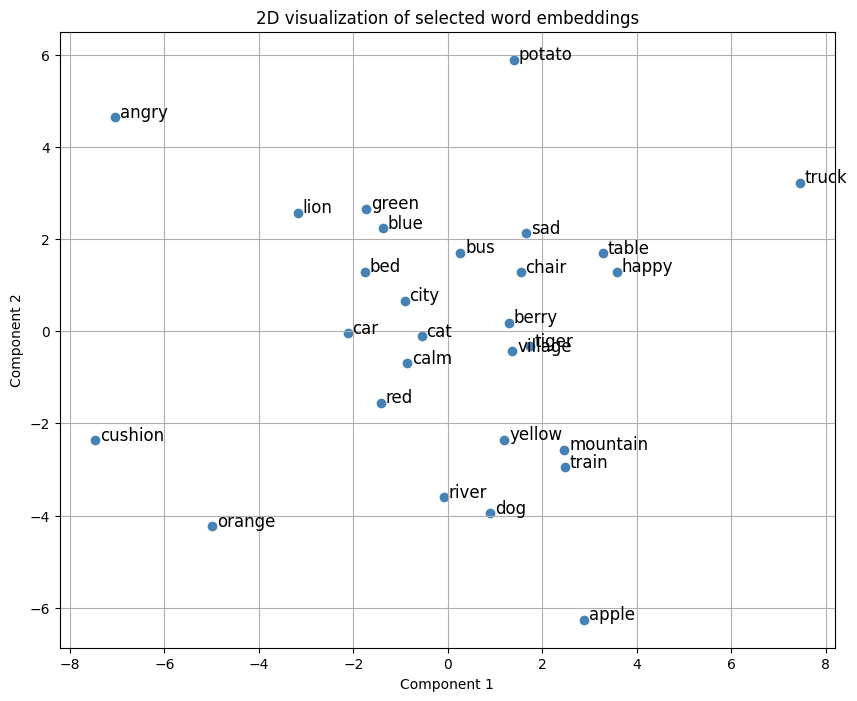

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

words = [
    "cat", "dog", "lion", "tiger",
    "car", "bus", "train", "truck",
    "apple", "berry", "orange", "potato",
    "chair", "table", "bed", "cushion",
    "city", "village", "river", "mountain",
    "red", "green", "blue", "yellow",
    "happy", "sad", "angry", "calm"
]

# Collect the embeddings for each of the words
embeddings = [] 
embedding_matrix = model.E.weight.data

for word in words:
    idx = data.word_to_id[word]
    emb = model.E.weight.data[idx].cpu().numpy()
    embeddings.append(emb)


embeddings = np.stack(embeddings)  # shape: (num_words, emb_dim)


# Option 1: t-SNE (good for semantic neighborhoods; slower)
#proj = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Option 2: PCA (fast and linear)
proj = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(proj[:, 0], proj[:, 1], color='steelblue')

for word, (x, y) in zip(words, proj):
    plt.text(x+0.1, y, word, fontsize=12)

plt.title("2D visualization of selected word embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()